In [ ]:
# ===================================================
# CNN-LSTM HYBRID - MULTI-MODAL PHISHING DETECTION
# URL + HTML CONTENT
# ===================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, roc_auc_score
)
from sklearn.preprocessing import LabelEncoder
from bs4 import BeautifulSoup
import re
from datetime import datetime
from tqdm import tqdm
import gc
from collections import Counter
import warnings
from concurrent.futures import as_completed
import multiprocessing as mp
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("="*60)
print("CNN-LSTM HYBRID - MULTI-MODAL PHISHING DETECTION")
print("URL + HTML CONTENT")
print("="*60)
print(f"Started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

CNN-LSTM HYBRID - MULTI-MODAL PHISHING DETECTION
URL + HTML CONTENT
Started at: 2025-10-28 16:56:50


In [ ]:
# ==============
# GPU SETUP
# ==============


print("GPU SETUP")

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    print("WARNING: GPU not available, using CPU")

print(f"Device: {device}")

GPU SETUP
PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4
GPU: NVIDIA GeForce GTX 1650
Device: cuda


In [ ]:
# =====================================
# LOAD PHRESHPHISH DATASET
# =====================================

print("LOADING PHRESHPHISH DATASET...")

from datasets import load_dataset

print("Loading dataset from cache...")
dataset = load_dataset("phreshphish/phreshphish", cache_dir='E:/.cache/huggingface')

print(f"Train samples: {len(dataset['train']):,}")
print(f"Test samples: {len(dataset['test']):,}")

# Extract URLs and labels 
print("\nExtracting URLs and labels...")
train_urls = dataset['train']['url']
train_labels = dataset['train']['label']
test_urls = dataset['test']['url']
test_labels = dataset['test']['label']

print(f"Done! {len(train_urls):,} train, {len(test_urls):,} test")

# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(train_labels)
y_test = le.transform(test_labels)

print(f"\nLabel distribution (train):")
unique, counts = np.unique(y_train, return_counts=True)
for label, count in zip(unique, counts):
    label_name = 'benign' if label == 0 else 'phish'
    print(f"  {label_name}: {count:,} ({count/len(y_train)*100:.1f}%)")




LOADING PHRESHPHISH DATASET
Loading dataset from cache...
Train samples: 371,941
Test samples: 36,787

Extracting URLs and labels...
✅ Done! 371,941 train, 36,787 test

Label distribution (train):
  benign: 253,189 (68.1%)
  phish: 118,752 (31.9%)


In [ ]:
# ==========================
# HTML PREPROCESSING
# ==========================

print("\n" + "="*60)
print("HTML PREPROCESSING")
print("="*60)

import pickle
import os

# Paths for cached cleaned HTML
CACHE_DIR = '../../../data/processed/url-detection/'
os.makedirs(CACHE_DIR, exist_ok=True)

TRAIN_HTML_CLEANED_PATH = os.path.join(CACHE_DIR, 'train_html_cleaned.pkl')
TEST_HTML_CLEANED_PATH = os.path.join(CACHE_DIR, 'test_html_cleaned.pkl')

# Check if cached cleaned HTML exists
if os.path.exists(TRAIN_HTML_CLEANED_PATH) and os.path.exists(TEST_HTML_CLEANED_PATH):
    print("\nFound cached cleaned HTML! Loading from disk...")
    
    with open(TRAIN_HTML_CLEANED_PATH, 'rb') as f:
        train_html_cleaned = pickle.load(f)
    
    with open(TEST_HTML_CLEANED_PATH, 'rb') as f:
        test_html_cleaned = pickle.load(f)
    
    print(f"Loaded train_html_cleaned: {len(train_html_cleaned):,} samples")
    print(f"Loaded test_html_cleaned: {len(test_html_cleaned):,} samples")
    print(f"Sample: {train_html_cleaned[0][:150]}...")
    
else:
    print("\nNo cached data found. Processing HTML from scratch...")
    print("This will take a while...")
    
    def clean_html(html):
        """Clean HTML content for tokenization"""
        if not html or len(html) == 0:
            return ""
        
        try:
            if len(html) > 50000:
                html = html[:50000]
            
            soup = BeautifulSoup(html, 'lxml')
            
            for tag in soup(['script', 'style', 'noscript', 'svg']):
                tag.decompose()
            
            text = soup.get_text(separator=' ', strip=True)
            
            forms = soup.find_all('form')[:3]
            form_actions = ' '.join([form.get('action', '')[:50] for form in forms])
            
            links = soup.find_all('a')[:5]
            link_hrefs = ' '.join([link.get('href', '')[:30] for link in links])
            
            title = soup.title.string if soup.title else ""
            if title and len(title) > 100:
                title = title[:100]
            
            combined = f"{title} {text[:5000]} {form_actions} {link_hrefs}"
            combined = re.sub(r'\s+', ' ', combined).strip()
            
            return combined[:10000]
            
        except Exception as e:
            return ""
    
    # Process train HTML
    train_html_cleaned = []
    for i in tqdm(range(0, len(dataset['train']), 1000), desc="Train HTML"):
        batch_end = min(i + 1000, len(dataset['train']))
        batch_html = dataset['train'][i:batch_end]['html']
        batch_cleaned = [clean_html(html) for html in batch_html]
        train_html_cleaned.extend(batch_cleaned)
        
        import gc
        gc.collect()
    
    # Process test HTML
    test_html_cleaned = []
    for i in tqdm(range(0, len(dataset['test']), 1000), desc="Test HTML"):
        batch_end = min(i + 1000, len(dataset['test']))
        batch_html = dataset['test'][i:batch_end]['html']
        batch_cleaned = [clean_html(html) for html in batch_html]
        test_html_cleaned.extend(batch_cleaned)
        
        import gc
        gc.collect()
    
    print(f"\nHTML cleaned!")
    print(f"Train: {len(train_html_cleaned):,}")
    print(f"Test: {len(test_html_cleaned):,}")
    
    # Save to disk for future use
    print("\nSaving cleaned HTML to disk...")
    
    with open(TRAIN_HTML_CLEANED_PATH, 'wb') as f:
        pickle.dump(train_html_cleaned, f)
    
    with open(TEST_HTML_CLEANED_PATH, 'wb') as f:
        pickle.dump(test_html_cleaned, f)
    
    print(f"Saved to {CACHE_DIR}")

print(f"\nAverage HTML length: {np.mean([len(h) for h in train_html_cleaned[:1000]]):.0f} chars")


HTML PREPROCESSING

Found cached cleaned HTML! Loading from disk...
Loaded train_html_cleaned: 371,941 samples
Loaded test_html_cleaned: 36,787 samples
Sample: Çoinbase Pro: Login | 𝘾oinbase Sign In Çoinbase Pro: Login | 𝘾oinbase Sign In 𝘾oinbase Sign In More Search Ctrl + K Çoinbase Pro: Login Powered by Git...

Average HTML length: 985 chars


In [ ]:
# ===================================
# HTML TOKENIZATION (WORD-LEVEL)
# ===================================

print('\n' + '='*60)
print("HTML TOKENIZATION")
print('='*60)
# Build HTML vocabulary
def build_html_vocab(html_texts, max_vocab=10000):
    """
    Build vocabulary from HTML text
    
    WHAT: Create mapping from words to indices
    WHY: Neural networks need numbers, not words
    HOW: Count word frequencies, keep top max_vocab words
    """
    word_counter = Counter()
    
    for text in tqdm(html_texts, desc="Building vocab"):
        words = text.lower().split()
        word_counter.update(words)
    
    # Get most common words
    most_common = word_counter.most_common(max_vocab - 2)
    
    # Create vocabulary
    word_to_idx = {'<PAD>': 0, '<UNK>': 1}
    for idx, (word, count) in enumerate(most_common, start=2):
        word_to_idx[word] = idx
    
    return word_to_idx

print("Building HTML vocabulary...")
html_word_to_idx = build_html_vocab(train_html_cleaned, max_vocab=10000)
html_vocab_size = len(html_word_to_idx)

print(f"HTML vocabulary size: {html_vocab_size:,} words")
print(f"Sample words: {list(html_word_to_idx.keys())[:20]}")

# Tokenize HTML
def tokenize_html(text, word_to_idx, max_length=2000):
    """
    Convert HTML text to sequence of word indices
    
    WHAT: text → list of numbers
    WHY: Neural networks need fixed-length numerical input
    HOW: Split text, map words to indices, pad to max_length
    """
    words = text.lower().split()[:max_length]
    tokens = [word_to_idx.get(word, 1) for word in words]  # 1 = <UNK>
    
    # Pad to max_length
    if len(tokens) < max_length:
        tokens += [0] * (max_length - len(tokens))
    
    return tokens

MAX_HTML_LENGTH = 2000  #lesser might be better based on lower amount of actual tokens in the processed html (~500)
print(f"Max HTML length: {MAX_HTML_LENGTH} tokens")

print("\nTokenizing HTML...")
X_train_html = np.array([tokenize_html(html, html_word_to_idx, MAX_HTML_LENGTH) 
                         for html in tqdm(train_html_cleaned, desc="Train")])
X_test_html = np.array([tokenize_html(html, html_word_to_idx, MAX_HTML_LENGTH) 
                        for html in tqdm(test_html_cleaned, desc="Test")])

print(f"\nHTML tokenized shapes:")
print(f"X_train_html: {X_train_html.shape}")
print(f"X_test_html: {X_test_html.shape}")


HTML TOKENIZATION
Building HTML vocabulary...


Building vocab: 100%|██████████| 371941/371941 [00:13<00:00, 27603.88it/s]


HTML vocabulary size: 10,000 words
Sample words: ['<PAD>', '<UNK>', 'the', 'to', 'and', 'of', 'a', 'in', 'your', '-', 'for', 'you', '|', 'is', 'with', '&', 'on', 'or', 'by', 'this']
Max HTML length: 2000 tokens

Tokenizing HTML...


Test: 100%|██████████| 36787/36787 [00:04<00:00, 8060.38it/s] 



HTML tokenized shapes:
X_train_html: (371941, 2000)
X_test_html: (36787, 2000)


In [ ]:
# ==========================================
# URL TOKENIZATION (CHARACTER-LEVEL)
# ==========================================

print("\n" + "="*60)
print("URL TOKENIZATION")
print("="*60)

# Convert Dataset columns to Python lists
print("Converting URL columns to lists...")
train_urls_list = list(train_urls)
test_urls_list = list(test_urls)

# Build character vocabulary
print("Building character vocabulary...")
all_urls = train_urls_list + test_urls_list
all_chars = set(''.join(all_urls))
char_to_idx = {char: idx + 1 for idx, char in enumerate(sorted(all_chars))}
char_to_idx['<PAD>'] = 0
char_vocab_size = len(char_to_idx)

print(f"URL vocabulary size: {char_vocab_size} characters")
print(f"Sample characters: {list(char_to_idx.keys())[:20]}")

# Tokenize URLs
def tokenize_url(url, char_to_idx, max_length=200):
    """Convert URL to sequence of character indices"""
    tokens = [char_to_idx.get(char, 0) for char in url[:max_length]]
    if len(tokens) < max_length:
        tokens += [0] * (max_length - len(tokens))
    return tokens

MAX_URL_LENGTH = 200

print("\nTokenizing URLs...")
X_train_url = np.array([tokenize_url(url, char_to_idx, MAX_URL_LENGTH) 
                        for url in tqdm(train_urls_list, desc="Train")])
X_test_url = np.array([tokenize_url(url, char_to_idx, MAX_URL_LENGTH) 
                       for url in tqdm(test_urls_list, desc="Test")])

print(f"\nURL tokenized shapes:")
print(f"X_train_url: {X_train_url.shape}")
print(f"X_test_url: {X_test_url.shape}")


URL TOKENIZATION
Converting URL columns to lists...
Building character vocabulary...
URL vocabulary size: 225 characters
Sample characters: [' ', '!', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4']

Tokenizing URLs...


Test: 100%|██████████| 36787/36787 [00:00<00:00, 212620.99it/s]



URL tokenized shapes:
X_train_url: (371941, 200)
X_test_url: (36787, 200)


In [ ]:
# =======================
# PYTORCH DATASET
# =======================

print("\n" + "="*60)
print("CREATING PYTORCH DATASETS")
print("="*60)

class MultiModalDataset(Dataset):
    """
    Dataset that returns both URL and HTML for each sample
    
    WHAT: Custom dataset for dual-input model
    WHY: PyTorch needs Dataset class to load data efficiently
    HOW: Return (url_tokens, html_tokens, label) for each index
    """
    def __init__(self, X_url, X_html, y):
        self.X_url = torch.LongTensor(X_url)
        self.X_html = torch.LongTensor(X_html)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X_url)
    
    def __getitem__(self, idx):
        return self.X_url[idx], self.X_html[idx], self.y[idx]

train_dataset = MultiModalDataset(X_train_url, X_train_html, y_train)
test_dataset = MultiModalDataset(X_test_url, X_test_html, y_test)

# Class weights
n_benign = (y_train == 0).sum()
n_phish = (y_train == 1).sum()
pos_weight = torch.tensor([n_benign / n_phish]).to(device)

print(f"Class weight (phishing): {pos_weight.item():.2f}")

# DataLoaders
BATCH_SIZE = 256 if torch.cuda.is_available() else 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Batch size: {BATCH_SIZE}")
print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")


CREATING PYTORCH DATASETS
Class weight (phishing): 2.13
Batch size: 256
Train batches: 1453
Test batches: 144


In [ ]:
# ========================
# ATTENTION MECHANISM
# ========================
#(Compute scores: How important is each token?)

class AttentionLayer(nn.Module):
    """
    Attention mechanism to focus on important parts
    
    WHAT: Learns which features are most important
    WHY: Not all parts of URL/HTML matter equally
    HOW: Computes attention weights, applies to features
    
    Example: ".tk" gets high weight, "https" gets low weight
    """
    def __init__(self, hidden_dim):
        super(AttentionLayer, self).__init__()
        self.attention = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        # x: (batch, seq_len, hidden_dim)
        attention_weights = torch.softmax(self.attention(x), dim=1)
        weighted = x * attention_weights
        return weighted, attention_weights

In [ ]:
# ===============================
# CNN-LSTM HYBRID ARCHITECTURE
# ===============================

class CNNLSTMHybrid(nn.Module):
    """
    Dual-branch CNN + LSTM for URL and HTML phishing detection
    
    ARCHITECTURE:
    1. URL Branch (CNN): Character-level pattern detection
    2. HTML Branch (CNN): Word-level pattern detection
    3. Concatenate: Combine both branches
    4. LSTM: Sequential understanding of combined features
    5. Dense: Final classification
    """
    def __init__(self, char_vocab_size, word_vocab_size):
        super(CNNLSTMHybrid, self).__init__()
        
        # URL BRANCH (Character-level CNN)
        
        self.url_embedding = nn.Embedding(char_vocab_size, 16, padding_idx=0)
        
        # Multiple kernel sizes to capture different n-gram patterns
        self.url_conv1 = nn.Conv1d(16, 256, kernel_size=3, padding=1)
        self.url_conv2 = nn.Conv1d(256, 256, kernel_size=5, padding=2)
        self.url_conv3 = nn.Conv1d(256, 128, kernel_size=7, padding=3)
        
        self.url_attention = AttentionLayer(128)
        
        # HTML BRANCH (Word-level CNN)
        
        self.html_embedding = nn.Embedding(word_vocab_size, 16, padding_idx=0)
        
        # Multiple kernel sizes for different phrase patterns
        self.html_conv1 = nn.Conv1d(16, 256, kernel_size=3, padding=1)
        self.html_conv2 = nn.Conv1d(256, 256, kernel_size=5, padding=2)
        self.html_conv3 = nn.Conv1d(256, 128, kernel_size=7, padding=3)
        
        self.html_attention = AttentionLayer(128)
        
        # LSTM FUSION (Bidirectional)
        
        # Input: 128 (URL) + 128 (HTML) = 256
        # Bidirectional LSTM doubles the output
        self.lstm = nn.LSTM(
            input_size=256,
            hidden_size=128,
            num_layers=2,
            bidirectional=True,
            batch_first=True,
            dropout=0.3
        )
        
        # CLASSIFICATION LAYERS
        
        # LSTM output: 128 * 2 (bidirectional) = 256
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.2)
    
    def forward(self, url_input, html_input):
        """
        Forward pass through the network
        
        Args:
            url_input: (batch, 200) - Character tokens
            html_input: (batch, 2000) - Word tokens
        
        Returns:
            output: (batch,) - Phishing probability logits
        """
        
        # PROCESS URL (Character CNN)
        
        # Embed: (batch, 200) → (batch, 200, 16)
        url_embed = self.url_embedding(url_input)
        
        # Transpose for Conv1D: (batch, 16, 200)
        url_embed = url_embed.transpose(1, 2)
        
        # Convolutions
        url_conv = self.relu(self.url_conv1(url_embed))  # (batch, 256, 200)
        url_conv = self.relu(self.url_conv2(url_conv))   # (batch, 256, 200)
        url_conv = self.relu(self.url_conv3(url_conv))   # (batch, 128, 200)
        
        # Transpose back: (batch, 200, 128)
        url_conv = url_conv.transpose(1, 2)
        
        # Attention
        url_features, url_attention_weights = self.url_attention(url_conv)
        
        # Global max pooling: (batch, 128)
        url_features = torch.max(url_features, dim=1)[0]
        
        # PROCESS HTML (Word CNN)
        
        # Embed: (batch, 2000) → (batch, 2000, 16)
        html_embed = self.html_embedding(html_input)
        
        # Transpose for Conv1D: (batch, 16, 2000)
        html_embed = html_embed.transpose(1, 2)
        
        # Convolutions
        html_conv = self.relu(self.html_conv1(html_embed))  # (batch, 256, 2000)
        html_conv = self.relu(self.html_conv2(html_conv))   # (batch, 256, 2000)
        html_conv = self.relu(self.html_conv3(html_conv))   # (batch, 128, 2000)
        
        # Transpose back: (batch, 2000, 128)
        html_conv = html_conv.transpose(1, 2)
        
        # Attention
        html_features, html_attention_weights = self.html_attention(html_conv)
        
        # Global max pooling: (batch, 128)
        html_features = torch.max(html_features, dim=1)[0]
        
        # COMBINE FEATURES
        
        # Concatenate URL and HTML features: (batch, 256)
        combined = torch.cat([url_features, html_features], dim=1)
        
        # Expand for LSTM: (batch, 1, 256)
        # LSTM expects (batch, sequence, features)
        combined = combined.unsqueeze(1)
        
        # LSTM SEQUENTIAL PROCESSING
        
        # LSTM: (batch, 1, 256) → (batch, 1, 256)
        # 256 = 128 hidden * 2 (bidirectional)
        lstm_out, _ = self.lstm(combined)
        
        # Remove sequence dimension: (batch, 256)
        lstm_out = lstm_out.squeeze(1)
        
        # CLASSIFICATION
        
        x = self.relu(self.fc1(lstm_out))
        x = self.dropout1(x)
        
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        
        x = self.fc3(x)
        
        return x.squeeze(), url_attention_weights, html_attention_weights

In [ ]:
# ========================
# INITIALIZE MODEL
# ========================

print("\n" + "="*60)
print("MODEL ARCHITECTURE")
print("="*60)

model = CNNLSTMHybrid(char_vocab_size, html_vocab_size)
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"\nModel summary:")
print(model)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2, verbose=True
)

print(f"\nOptimizer: Adam (lr=0.001)")
print(f"Loss: BCEWithLogitsLoss (pos_weight={pos_weight.item():.2f})")


MODEL ARCHITECTURE

Total parameters: 2,135,571
Trainable parameters: 2,135,571

Model summary:
CNNLSTMHybrid(
  (url_embedding): Embedding(225, 16, padding_idx=0)
  (url_conv1): Conv1d(16, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (url_conv2): Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
  (url_conv3): Conv1d(256, 128, kernel_size=(7,), stride=(1,), padding=(3,))
  (url_attention): AttentionLayer(
    (attention): Linear(in_features=128, out_features=1, bias=True)
  )
  (html_embedding): Embedding(10000, 16, padding_idx=0)
  (html_conv1): Conv1d(16, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (html_conv2): Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
  (html_conv3): Conv1d(256, 128, kernel_size=(7,), stride=(1,), padding=(3,))
  (html_attention): AttentionLayer(
    (attention): Linear(in_features=128, out_features=1, bias=True)
  )
  (lstm): LSTM(256, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc1): Li

In [11]:
# ============================================
# TRAINING FUNCTIONS
# ============================================

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for batch_url, batch_html, batch_y in tqdm(loader, desc="Training", leave=False):
        batch_url = batch_url.to(device)
        batch_html = batch_html.to(device)
        batch_y = batch_y.to(device)
        
        optimizer.zero_grad()
        
        outputs, _, _ = model(batch_url, batch_html)
        loss = criterion(outputs, batch_y)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        preds = torch.sigmoid(outputs) > 0.5
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())
    
    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    
    return avg_loss, accuracy, f1, recall

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for batch_url, batch_html, batch_y in tqdm(loader, desc="Evaluating", leave=False):
            batch_url = batch_url.to(device)
            batch_html = batch_html.to(device)
            batch_y = batch_y.to(device)
            
            outputs, _, _ = model(batch_url, batch_html)
            loss = criterion(outputs, batch_y)
            
            total_loss += loss.item()
            
            probs = torch.sigmoid(outputs)
            preds = probs > 0.5
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    
    return avg_loss, accuracy, precision, recall, f1, all_preds, all_probs

In [ ]:
# ==========================
# TRAINING LOOP
# ==========================

print("\n" + "="*60)
print("TRAINING")
print("="*60)

NUM_EPOCHS = 10
best_f1 = 0
history = {
    'train_loss': [], 'train_acc': [], 'train_f1': [], 'train_recall': [],
    'val_loss': [], 'val_acc': [], 'val_precision': [], 'val_recall': [], 'val_f1': []
}

print(f"Training for {NUM_EPOCHS} epochs...")
print("Expected time: 2-3 hours with GPU\n")
training_start = datetime.now()

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    
    # Train
    train_loss, train_acc, train_f1, train_recall = train_epoch(
        model, train_loader, criterion, optimizer, device
    )
    
    # Evaluate
    val_loss, val_acc, val_prec, val_recall, val_f1, _, _ = evaluate(
        model, test_loader, criterion, device
    )
    
    # Update scheduler
    scheduler.step(val_f1)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_f1'].append(train_f1)
    history['train_recall'].append(train_recall)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_precision'].append(val_prec)
    history['val_recall'].append(val_recall)
    history['val_f1'].append(val_f1)
    
    # Print metrics
    print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc*100:.2f}%, F1: {train_f1*100:.2f}%, Recall: {train_recall*100:.2f}%")
    print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_acc*100:.2f}%, Prec: {val_prec*100:.2f}%, Recall: {val_recall*100:.2f}%, F1: {val_f1*100:.2f}%")
    
    # Save best model
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), '../../../models/url-detection/cnn_lstm_best.pth')
        print(f"Best model saved! (F1: {best_f1*100:.2f}%)")

training_end = datetime.now()
training_time = (training_end - training_start).total_seconds()

print(f"\nTraining complete")
print(f"Total time: {training_time/60:.2f} minutes")
print(f"Best validation F1: {best_f1*100:.2f}%")


TRAINING
Training for 10 epochs...
Expected time: 2-3 hours with GPU


Epoch 1/10


Train - Loss: 0.3310, Acc: 89.22%, F1: 83.78%, Recall: 87.22%
Val   - Loss: 0.3031, Acc: 92.51%, Prec: 81.14%, Recall: 77.04%, F1: 79.04%
Best model saved! (F1: 79.04%)

Epoch 2/10


Train - Loss: 0.1275, Acc: 97.03%, F1: 95.37%, Recall: 95.65%
Val   - Loss: 0.2010, Acc: 95.74%, Prec: 91.05%, Recall: 85.10%, F1: 87.97%
Best model saved! (F1: 87.97%)

Epoch 3/10


Train - Loss: 0.0699, Acc: 98.39%, F1: 97.48%, Recall: 97.87%
Val   - Loss: 0.1758, Acc: 96.17%, Prec: 90.30%, Recall: 88.59%, F1: 89.44%
Best model saved! (F1: 89.44%)

Epoch 4/10


Train - Loss: 0.0511, Acc: 98.81%, F1: 98.15%, Recall: 98.56%
Val   - Loss: 0.1936, Acc: 96.48%, Prec: 93.73%, Recall: 86.56%, F1: 90.00%
Best model saved! (F1: 90.00%)

Epoch 5/10


Train - Loss: 0.0398, Acc: 99.04%, F1: 98.51%, Recall: 98.95%
Val   - Loss: 0.1743, Acc: 96.62%, Prec: 93.78%, Recall: 87.33%, F1: 90.44%
Best model saved! (F1: 90.44%)

Epoch 6/10


Train - Loss: 0.0317, Acc: 99.26%, F1: 98.85%, Recall: 99.17%
Val   - Loss: 0.1917, Acc: 96.57%, Prec: 91.33%, Recall: 89.84%, F1: 90.57%
Best model saved! (F1: 90.57%)

Epoch 7/10


Train - Loss: 0.0265, Acc: 99.35%, F1: 98.98%, Recall: 99.33%
Val   - Loss: 0.2670, Acc: 96.75%, Prec: 95.01%, Recall: 86.82%, F1: 90.73%
Best model saved! (F1: 90.73%)

Epoch 8/10


Train - Loss: 0.0222, Acc: 99.47%, F1: 99.17%, Recall: 99.44%
Val   - Loss: 0.2785, Acc: 96.93%, Prec: 95.92%, Recall: 86.94%, F1: 91.21%
Best model saved! (F1: 91.21%)

Epoch 9/10


Train - Loss: 0.0186, Acc: 99.53%, F1: 99.27%, Recall: 99.54%
Val   - Loss: 0.2405, Acc: 96.86%, Prec: 94.56%, Recall: 87.94%, F1: 91.13%

Epoch 10/10


Train - Loss: 0.0157, Acc: 99.62%, F1: 99.40%, Recall: 99.62%
Val   - Loss: 0.2442, Acc: 96.97%, Prec: 94.76%, Recall: 88.37%, F1: 91.45%
Best model saved! (F1: 91.45%)

Training complete!
Total time: 190.47 minutes
Best validation F1: 91.45%



THRESHOLD OPTIMIZATION

Getting predictions on test set...


Predicting: 100%|██████████| 144/144 [00:28<00:00,  4.99it/s]



FINDING OPTIMAL THRESHOLD

✅ FOUND THRESHOLDS THAT MEET CRITERIA (Precision ≥ 90%, Recall ≥ 90%):

Top 5 candidates:
Threshold    Precision    Recall       F1-Score    
--------------------------------------------------
0.3061       92.53        90.09        91.29       
0.3048       92.52        90.09        91.29       
0.3062       92.53        90.07        91.29       
0.3039       92.50        90.09        91.28       
0.3069       92.53        90.06        91.28       

BEST THRESHOLD: 0.3061
   Precision: 92.53%
   Recall:    90.09%
   F1-Score:  91.29%


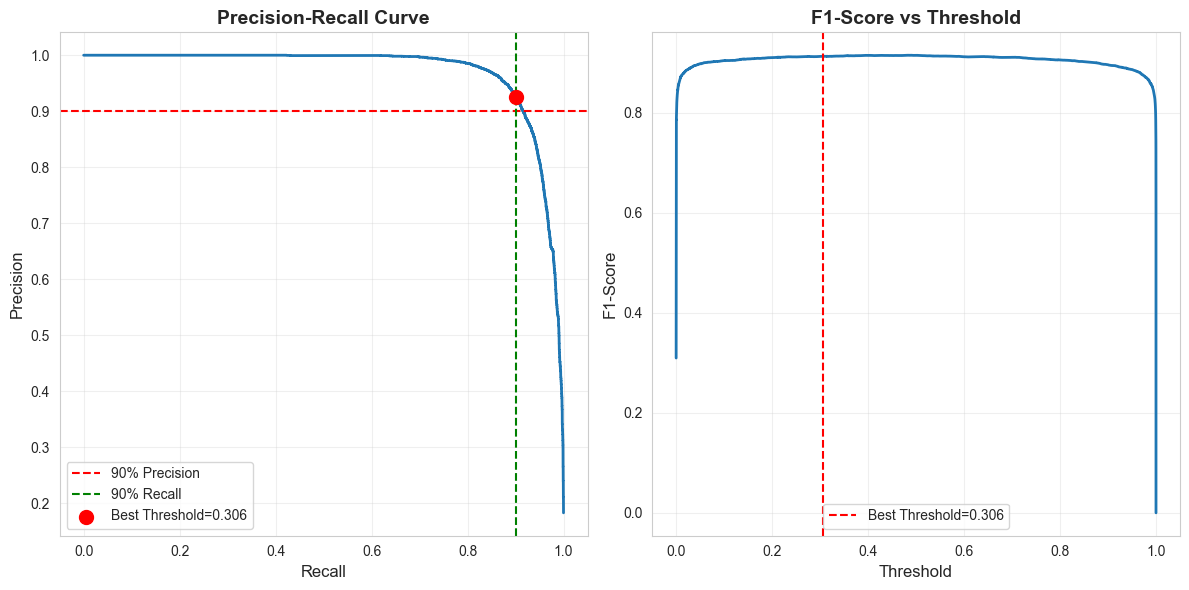


FINAL RESULTS WITH OPTIMIZED THRESHOLD

Original (threshold=0.5):
  Precision: 94.76%
  Recall:    88.37%
  F1-Score:  91.45%
  Accuracy:  96.97%

Optimized (threshold=0.3061):
  Precision: 92.53%
  Recall:    90.09%
  F1-Score:  91.29%
  Accuracy:  96.85%

Improvement:
  Precision: -2.23%
  Recall:    +1.72%
  F1-Score:  -0.16%

Optimal threshold saved to optimal_threshold.json


In [ ]:
# ============================================
# THRESHOLD TUNING FOR OPTIMAL RECALL
# ============================================

print("\n" + "="*60)
print("THRESHOLD OPTIMIZATION")
print("="*60)

from sklearn.metrics import precision_recall_curve, f1_score
import matplotlib.pyplot as plt

# Load best model
model.load_state_dict(torch.load('../../../models/url-detection/cnn_lstm_best.pth'))
model.eval()

# Get predictions (probabilities) on test set
print("\nGetting predictions on test set...")
all_probs = []

with torch.no_grad():
    for batch_url, batch_html, batch_y in tqdm(test_loader, desc="Predicting"):
        batch_url = batch_url.to(device)
        batch_html = batch_html.to(device)
        
        outputs, _, _ = model(batch_url, batch_html)
        probs = torch.sigmoid(outputs)
        all_probs.extend(probs.cpu().numpy())

y_probs = np.array(all_probs)

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Find threshold that gives 90%+ recall AND 90%+ precision
print("\n" + "="*60)
print("FINDING OPTIMAL THRESHOLD")
print("="*60)

candidates = []
for i, thresh in enumerate(thresholds):
    if recall[i] >= 0.90 and precision[i] >= 0.90:
        f1 = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
        candidates.append({
            'threshold': thresh,
            'precision': precision[i],
            'recall': recall[i],
            'f1': f1
        })

if candidates:
    # Sort by F1 score
    candidates = sorted(candidates, key=lambda x: x['f1'], reverse=True)
    
    print("\nFOUND THRESHOLDS THAT MEET CRITERIA (Precision ≥ 90%, Recall ≥ 90%):")
    print("\nTop 5 candidates:")
    print(f"{'Threshold':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
    print("-" * 50)
    
    for i, cand in enumerate(candidates[:5]):
        print(f"{cand['threshold']:<12.4f} {cand['precision']*100:<12.2f} {cand['recall']*100:<12.2f} {cand['f1']*100:<12.2f}")
    
    # Use best threshold
    best_thresh = candidates[0]['threshold']
    best_prec = candidates[0]['precision']
    best_rec = candidates[0]['recall']
    best_f1 = candidates[0]['f1']
    
    print(f"\nBEST THRESHOLD: {best_thresh:.4f}")
    print(f"   Precision: {best_prec*100:.2f}%")
    print(f"   Recall:    {best_rec*100:.2f}%")
    print(f"   F1-Score:  {best_f1*100:.2f}%")
    
else:
    # Find threshold closest to 90% recall
    target_recall_idx = np.argmin(np.abs(recall - 0.90))
    best_thresh = thresholds[target_recall_idx]
    best_prec = precision[target_recall_idx]
    best_rec = recall[target_recall_idx]
    best_f1 = 2 * (best_prec * best_rec) / (best_prec + best_rec)
    
    print("\nNo threshold gives BOTH precision AND recall ≥ 90%")
    print(f"\nBest threshold for ~90% recall: {best_thresh:.4f}")
    print(f"   Precision: {best_prec*100:.2f}%")
    print(f"   Recall:    {best_rec*100:.2f}%")
    print(f"   F1-Score:  {best_f1*100:.2f}%")
    

# Visualize Precision-Recall curve
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(recall, precision, linewidth=2)
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Precision')
plt.axvline(x=0.90, color='g', linestyle='--', label='90% Recall')
plt.scatter([best_rec], [best_prec], color='red', s=100, zorder=5, label=f'Best Threshold={best_thresh:.3f}')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])
plt.plot(thresholds, f1_scores, linewidth=2)
plt.axvline(x=best_thresh, color='r', linestyle='--', label=f'Best Threshold={best_thresh:.3f}')
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('F1-Score', fontsize=12)
plt.title('F1-Score vs Threshold', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Evaluate with best threshold
y_pred_optimized = (y_probs >= best_thresh).astype(int)

final_acc = accuracy_score(y_test, y_pred_optimized)
final_prec = precision_score(y_test, y_pred_optimized)
final_rec = recall_score(y_test, y_pred_optimized)
final_f1 = f1_score(y_test, y_pred_optimized)

print("\n" + "="*60)
print("FINAL RESULTS WITH OPTIMIZED THRESHOLD")
print("="*60)

print(f"\nOriginal (threshold=0.5):")
print(f"  Precision: 94.76%")
print(f"  Recall:    88.37%")
print(f"  F1-Score:  91.45%")
print(f"  Accuracy:  96.97%")

print(f"\nOptimized (threshold={best_thresh:.4f}):")
print(f"  Precision: {final_prec*100:.2f}%")
print(f"  Recall:    {final_rec*100:.2f}%")
print(f"  F1-Score:  {final_f1*100:.2f}%")
print(f"  Accuracy:  {final_acc*100:.2f}%")

print(f"\nImprovement:")
print(f"  Precision: {(final_prec - 0.9476)*100:+.2f}%")
print(f"  Recall:    {(final_rec - 0.8837)*100:+.2f}%")
print(f"  F1-Score:  {(final_f1 - 0.9145)*100:+.2f}%")


# Save optimized threshold
optimal_config = {
    'threshold': float(best_thresh),
    'precision': float(final_prec),
    'recall': float(final_rec),
    'f1_score': float(final_f1),
    'accuracy': float(final_acc)
}

import json
with open('../../../models/url-detection/optimal_threshold.json', 'w') as f:
    json.dump(optimal_config, f, indent=2)

print(f"\nOptimal threshold saved to optimal_threshold.json")